## タイタニックのデータサイエンスソリューション

---

### 私は新しいpythonパッケージ「Speedml」をリリースして、このノートブックでそのテクニックを伝授しましょう。直感的でパワフルで生産性が高いAPIですよ！

Speedmlを使って僕は下位20%から上位20%に何回かでなれたんだ！
さらに、しかもコードは70%も少なくなる。

###　下記のURLでダウンロードして試してみてくれ！  
[Titanic Solution using Speedml](https://github.com/Speedml/notebooks/blob/master/titanic/titanic-solution-using-speedml.ipynb).

---

このノートブックはデータサイエンスソリューションという本の仲間で、kaggleのようなデータサイエンスコンペを解くための典型的なワークフローを説明していきます。

データサイエンスコンペティションの入門するためのすばらしいノートブックはいくつかあるんだけど、その多くはコンペのプロ中のプロが作っているからか、どうやってそのやりかたをやるのかっていう説明が抜けていることがあるんだ。
このノートブックの目的はワークフローを一つ一つ丁寧に追って、すべてのステップでどうやってその決定にいたったかを説明していくよ。

### ワークフローステージ

コンペを解くワークフローはデータサイエンスブックに述べられるように７つのステージを経るんだ。

1. 問題定義
1. データを得る
1. データをきれいにする（前処理）
1. パターンを見つけて分析する
1. モデルを作って問題を解決
1. 人に分かりやすいように結果と過程を伝える資料を作る
1. 結果を提出する

なんだけどこれは一般的なケースだね。例外なんていくらでもあるよ。たとえば、

- 複数のステージを一緒にやることもある。可視化しながら分析したりね。
- さきほどの順番よりはやくやることもある。wrangleの前後で分析することもあるね。
- 同じステージを何回も繰り返すこともあります。よく可視化は何回もやるね。
- ステージを飛ばしたりすることもある。私はデータが既に用意されていたりね。

### 問題定義

kaggleだと大体データを与えられて解く問題も決まっているんだ。

タイタニックだと「生存者と死亡者のトレーニングデータを与えられて、テストセットの生死を判断する」だ。

問題のドメイン（前提知識）についても知っておくと役に立つかもね。

かいつまんでいうと

- 1912年4月15日の初航海でタイタニック号は氷山にぶつかる事故にあって、2224人中1502人が亡くなった。要は32%の人が生き残ったんだ。
- 一説には救命ボートが足りないから死者が増えたんじゃないかって言われている。
- 女性や子供、上級クラスの人は助かりやすかったらしいよ。

### ワークフローのゴール

データ分析ワークフローでは7つの主要な目的を解決するよ。

- 分類 
    - データを分類する。目的に対して異なる分類の関係性や意味合いを理解したい。
- 相関性
    - ある人はトレーニングセットにある特徴をもとに問題解決しようとする。どの特徴が解きたいゴールに対して有為に働くでしょうか？統計学で言う相関係数になります。ある係数が変化すると、目的変数も同じように変化したり、その逆になったり。これは数値データでもカテゴリーデータどちらでもテストできます。特徴間を関連付けることは特徴を作ったり、修正したり、集めたりするのに役立ちます。
- 変換
    - モデル学習するとき、データを準備する必要があります。学習アルゴリズムによると思いますが、すべての特徴を同等な数値データにする必要があるものもあります。だからたとえばテキストカテゴリーを数値に変換したりします。
- 値を埋める（コンプリート）
    - 前処理で欠損値を何らかの値で埋める必要があります。欠損値がないとき学習アルゴリズムは最もよく働きます。
- 直す
    - 誤ったデータを直す。
- 生み出す
    - 特徴量エンジニアリングで新しい特徴量を生み出す。
- チャート化
    - 目的やデータの性質を端的に表したよいチャートを作る。

In [1]:
# データを扱うモジュール
import pandas as pd
import numpy as np
import random as rnd

# 可視化モジュール
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 機械学習モジュール
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

上記の機械学習モジュールをかんたんにまとめる

In [2]:
# データを手に入れる
data_dir = '/Users/kzfm/Desktop/dive/diveintocode-term0/week3-EDA/competitions/titanic/'
train_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
combine = [train_df, test_df]

In [3]:
# 項目をリストとして表示
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


項目を出してどれがカテゴリーでどれが数値か見分けよう


In [12]:
# head()でデータをかいつまんで見れるよ
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 入り混じったデータはあるかな？

数値とアルファベットが混じったデータはあるかな。これは修正すべき項目だ。

- TicketとCabinは数値とアルファベットが混じっているね。

### 誤りやタイポのあるデータはある？

データがでかいと難しいけど、小さいデータセットのすこしのサンプルなら修正する必要があるか明らかだね。

- 名前はいろいろまずそう。

In [13]:
# 先頭から5件表示
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### null値や空白、空データがあるか？

これらは修正の必要があるね。

- Cabin、Age、Embarkedはヌル値があるね。
- CabinとAgeは不十分だね。

### データ型は何？

変換目的で助けてくれる。

- ７つは整数か実数型。　テストの場合は6つ (survivedがない)
- 5つは文字型

In [14]:
# データの情報（型やヌル値の有無、項目数）をかんたんに見られる
# とれー
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

### 数値項目の分布はどうなっている？

データの外観をぱっとつかむのに分布を見てみるのはいいことです。

- サンプルは891で2224人のうち40%ほど
- Survivedの項目は0,1データ
- サンプルは38%生き残っているが実際は32%
- 75%以上の乗客は親や子供と一緒ではない。
- ほぼ30%の人が兄弟や親戚と乗っている。
- 1%未満の人は512ドル以上払っている
- 高齢者（65-80才）はほとんどいない(1%未満)です。


In [15]:
# 各項目ごとの統計情報を表示
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### カテゴリーデータの分布はどうでしょうか？

- 名前にかぶりはない 
- 性別は２つの取りうる値があって　６５％が男だ
- 客室はかぶっているのもあるから、同じ客室に泊まっていた人もいるんだね。
- 乗った港は３つだね。S（シェルブール）が一番多いみたい。
- チケットは22%がかぶっているみたい。

In [18]:
train_df.describe(include=['O'])
# データ型を指定して表示（Oはオブジェクト型）

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Nosworthy, Mr. Richard Cater",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


### データ分析の仮説

これまで長々データを分析してきて下記の仮説にたどり着いた。
適切なアクションを取る前に更に仮説を検証してみよう。

#### 関係性

どの特徴がどの程度生死に関わるかを知りたい。　早めにこれをやってモデル化につなげたい。

#### 仕上げる（全部の項目を埋める）

1. 確実に生死に関わってくるからAgeの項目は埋めたいな。
1. 乗った港やその他も生死に関係しそうだから埋めたいな。

#### 修正

1. チケットの番号はかぶりも多いし生死に関係ないから消しちゃおう。
1. 乗客室の番号もかなり不十分でnullが多いから消してしまおう。
1. 乗客IDも関係ないから消しちゃおう
1. 名前も関係ないから消しちゃおう。

#### 生成

1. ParchとSibSpから「Family」項目を追加しましょう
1. 名前をもとにして(Title)を作りましょう
1. 「年齢層」を作りましょう。　連続する数値型から順序のあるカテゴリーデータに切り替えます。
1. Fareレンジをもし役に立ちそうなら作りましょう。

#### 分類

最初の説明にあった情報をもとに仮説を加えましょう。

1. 女性は生き残りやすかった。
1. 子供は生き残りやすかった。（何歳以下にしよう？）
1. ファーストクラスの人は生き残りやすかった。

### ピボットをつかった分析

調査や仮説を決めたら、さっと項目をピポッドして関係性を分析しましょう。
これは空の項目のない特徴間でしかできない。
これは今のところ性別、クラス、親戚や兄弟の数と親子の数にしかできないってこと。

- **Pclass** ファーストクラスは顕著な関係があるね。モデルに加えよう。
- **Sex** 女性は74%という高い生存率だね
- **SibSp and Parch** あんまり関係がなさそう


In [19]:
# クラスごとの生存フラグの平均、つまり生存率を集計してソートして表示
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# クラスが上なほど生き残りやすい。世知辛い！

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [23]:
# 性別ごとの生存フラグの平均、つまり生存率を集計してソートして表示
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [24]:
# 親族や兄弟の数ごとの生存フラグの平均、つまり生存率を集計してソートして表示
train_df[["SibSp", 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [28]:
# 親や子供の数ごとの生存フラグの平均、つまり生存率を集計してソートして表示
train_df[['Parch','Survived']].groupby('Parch', as_index=False).mean().sort_values(by='Survived', ascending=False)#.reset_index()

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### データの可視化による分析

今までの仮説が確かなのか可視化してみてみましょう。

#### 関係性のある数値データ

さて目的変数と従属変数の関係性について理解しましょう。

ヒストグラムは連続する数値データに対して分布を見るのに便利です。
ヒストグラムは区切り幅や数を自動で決めてくれる。
幼児が生き残りやすいのがわかったりする。

#### 観測結果

- 4歳児以下の幼児の生存率が高い
- 最高齢の80才の人は生き残った。
- 15-25才の大多数は生き残れなかった。
- ほとんどの人は15-35才だった。

#### 結論

この簡単な分析で次のステップでどうするかの仮説を固めましょう。

- 年齢は考慮すべき。
- 年齢のヌル値は埋めよう
- 「年齢層」の項目をつけよう

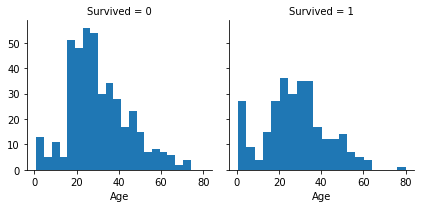

In [30]:
# Survived項目ごとにヒストグラムを表示する
g = sns.FacetGrid(train_df, col="Survived")
g.map(plt.hist, 'Age', bins=20)
# 生存者と死亡者の年齢層を確認できる。

### 数値と順序のある特徴を関係づける


??

#### 観測してわかったこと

- ほとんどの乗客はPclass=3だけどほとんど生き残れなかった。仮説#2がたしかになった。
- クラス2,3の幼児は一番生きのこった。更に仮説#2が強固になった。
- ファーストクラスの人はほとんど生き残った。分類仮説#3がたしかになった。
- クラスは年齢層によっと変わります。

#### 決めたこと

- モデル学習にPclassを考慮に入れよう

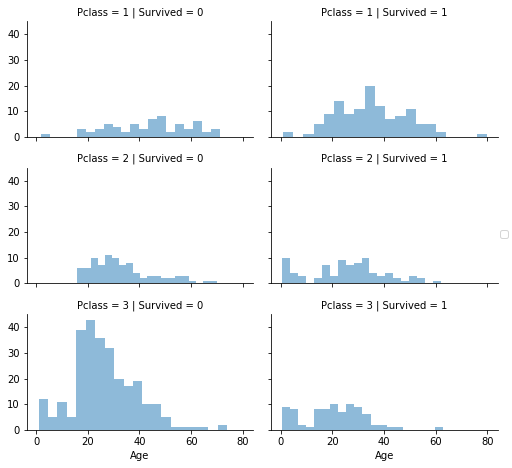

In [4]:
# grid = sns.FacetGrid(train_df, col='Survived', hue='Survived')
# 生死とクラスごとに年齢層をヒストグラムで表示する
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();
# 3rdクラスの若者は助からない...

### カテゴリーデータの関係性

さて、解決すべきゴールに向かってカテゴリーデータの関係性を見ていきましょう。

#### 観測してわかったこと

- 女性は男性より生き残りやすい。分類仮説#1が確かになった。
- ただシェルブールで乗った男は高い生存率だった。クラスと乗った港との関係性はクラスと生存率の関係を変えるかも、かならずしも
乗った港と生存率が直接関係しているとは言わないけど。
- ３クラスの男性はC,Q港から乗った２クラスの人より生存率が高い。#2を確定させよう。
- 乗船港は３クラスや男性に対して生存率を変化させる。 #1を修正しよう。

#### 決めたこと

- 性別を学習器に加えよう。
- 乗船港も加えよう。

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


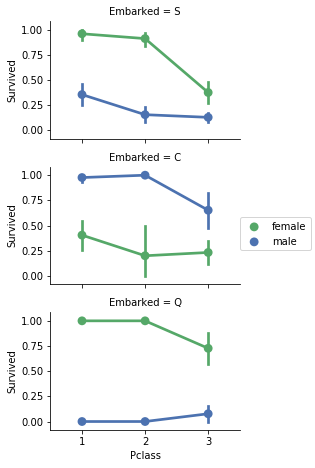

In [32]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()
# 警告の内容は
# カテゴリーデータをならべる順番を指定しないと勝手に推論するから注意してね

### 数値とカテゴリーデータの関係性

カテゴリーデータと数値データの関係性も調べたい。
乗船港、性別、運賃と生存したかの関係性を考えましょう。

#### 観測してわかったこと

- 乗船運賃が高い人ほど生き残りやすい。運賃幅を作って、 #4を確かにしましょう。
- 乗船港は生存率に関係している。#1を修正して、#2をcompleteしよう。

#### 決めたこと

- 乗船運賃の価格帯も考慮しよう。

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


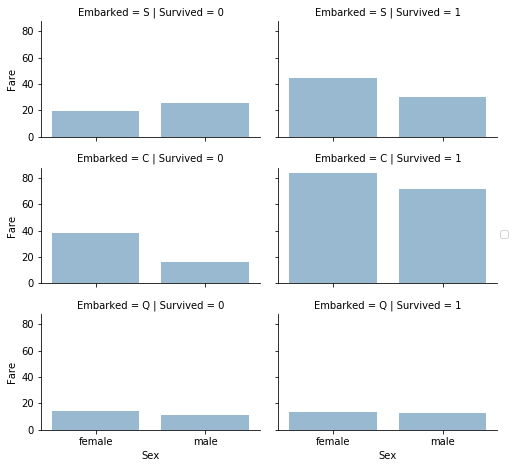

In [8]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
# 出港した港と生死ごとの男女別バープロット
grid = sns.FacetGrid(train_df, row='Embarked', col="Survived", size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend() # 凡例を書いて再描画、空欄では意味がない？　はずしても変わらなかった
# CとS港は生存率が上がる

### Wrangle data

今までデータや解決要件に関するいくつかの仮説や決定をまとめました。
いままでのところ、項目や値を変更していませんでした。
目的のための仮説や決定を実行しましょう。

#### 特徴を削って修正する

削るのは目的達成にとってよいことです。
特徴を削ると少ない特徴を扱うだけで済みます。ノートブックを加速させて、分析を楽にします。

仮説や決定に基づいて、CabinとTicketを削りたい。

やるときはトレーニングセットとテストセットどちらも削って一貫性を保ちましょう。

In [35]:
# まず削る前の行列の数を表示する
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)


In [9]:
# トレーニングセットとテストセットどちらもticketとcabinの項目を削る
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
# トレーニングセットとテストセットを結合
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

('After', (891, 10), (418, 9), (891, 10), (418, 9))

#### 新しい特徴を作って既存の項目をはずす

「名前」と「乗船ID」
「名前」から抽出して「title」をつけて、それと生存率の関係性を調べたい。

次のコードで正規表現を使ってTitleを抽出します。
正規表現パターン(\w+\.)は.で終わる最初のワードにマッチします。
expand=FalseだとDataFrameを返します。

#### 観測してわかったこと

Title,年齢、生存しているかをプロットしてみて、下記のことがわかった。

- 殆どのtitleは年齢層を如実に表します。例えばMasteタイトルの平均は５才です。
- TitleAgeのバンドで生き残るかはかなり変わる
- あるタイトル(Mme, Lady, Sir)はほとんど生き残り、(Don, Rev,Jonkheer)は亡くなった。

#### 決めたこと

- 新しく作ったTitleは（関係ありそうだから）学習器に加えよう

In [43]:
# .前に始まる文字を抽出してTitle（肩書）に入れる
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


多くの肩書は一般的な名前で置き換えて残りは「レア」にしよう。

In [44]:
# 肩書をRare、Miss,Mrsに置換して５種類に統一する。
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# 肩書ごとの生存率を集計
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
# MissやMrs,Masterが生存率が高い

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


肩書カテゴリーを順序のある数値にしておきましょう。

In [45]:
# カテゴリデータを順序のある数値に置き換える
# 何かと扱いやすくなる
title_mapping = {'Mr': 1, 'Miss':2, 'Mrs':3, 'Master':4, "Rare":5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


安全にテストとトレーニングセットから名前を削除したい。
またトレーニングセットの乗船IDも必要ないね。

In [46]:
# 名前と乗車券のIDも関係ないので削る
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
# combineにトレーニングセットとテストセットを結合して確認　
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### カテゴリーデータの変換

文字と数値が混じったデータを変換したいね。
これはだいたいの学習アルゴリズムで必要なことなんだ。
そうすることで、ゴールに近づける

In [47]:
# 性別も01データに変換する
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female':1, 'male': 0}).astype(int)
    
# 確認する
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### 数値連続データを埋める

次にヌル値や欠損値を補完して埋めるのに取り掛かろう。
まず年齢から。
連続値を埋めるのには３つの方法があります。

1. かんたんなのは平均から上下標準偏差の幅の乱数を埋める（乱暴！）
1. より正確なやり方は他の関係する値を使って推測する方法。このケースでは年齢は性別、クラスに関係しているのでそれぞれの条件での中央値を取る。クラス1で男性、クラス２で男性、クラス３で男性みたいにね。
1. １と２を組み合わせてみよう。中央値を使う代わりに、平均とその標準偏差の間の乱数を使う。もちろんクラスと性別ごとの平均値と標準偏差を使ってね。

１，３の方法は乱数ノイズがはいるね。それは乱数値によって結果が変わってくるかもしれない。
（検証のときにやりづらい）
だから２の方法を使おう。

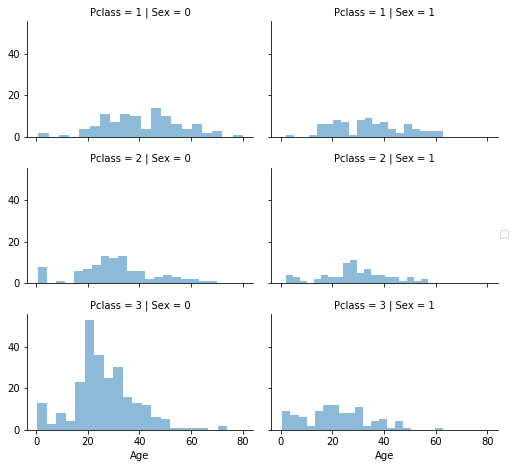

In [48]:
# grid = sns.FacetGrin(train_df, col='Pclass', hue='Gender')
# まずクラスと性別ごとの年齢層の分布を確認する
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

さっきの方法で埋める値をいれるための配列を用意しよう。

In [51]:
# クラスと性別ごとの年齢の補完値を格納する変数を用意
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

じゃあ性別(0,1)とクラス(1,2,3)をイテレートして補完する値を計算しよう。　

In [58]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            # 欠損値を除いた　対象の性別、クラスの年齢を抽出
            guess_df = dataset[(dataset['Sex'] == i) & \
                              (dataset['Pclass'] == j+1 )]['Age'].dropna()
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            
            # 上記は方法3で今回は簡略的に中央値を使用する
            age_guess = guess_df.median()
            
            # Convert random age float to nearest .5 age 0.5刻みの値にする
            guess_ages[i, j] = int( age_guess/0.5 + 0.5) * 0.5
    
    # null値に上記で得た補完年齢をセットする
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]
    dataset['Age'] = dataset['Age'].astype(int)

# head()で確認
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


年齢層を作って、生存したかとの関係を決めよう

In [59]:
# 年齢を５つのグループに分けてAgeBand項目を使う
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# AgeBandで生存率を集計してソートして表示する
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


年齢を年齢層に置き換えましょう。

In [61]:
# 上記の年齢層の幅に沿ってAgeをカテゴリーデータ（ordinalな）に置き換える
for dataset in combine:
    dataset.loc[ dataset['Age'] < 16,  'Age'] =0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ (dataset['Age'] > 64), 'Age'] = 4
# 最後に確認を忘れない
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


最後に年齢層を取り除きましょう

In [62]:
# Ageをカテゴリーデータにして役目を終えたAgeBandを取り除く
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### 既存の特徴を組み合わせて新しい特徴を作る

親族、兄弟の数と親と子の数から「家族数」を作りましょう。
これで「Parch」「SibSp」を削れます。

In [63]:
# 家族数を集計
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # 自分も含める

# 家族数ごとに生存率を集計し、生存率が大きい順にソートして表示する
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


もう一つ「お一人様」特徴を追加しましょう。

In [64]:
# 家族数が一人のひとはIsAlone項目に1立てる
for dataset in combine:
    dataset["IsAlone"] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1 
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()
# お一人様かどうかで生存率が変わるか確認
# 家族と乗っていたほうが生存率が20%も変わる

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


では家族数、Parch、SibSpを消して、IsAloneに譲りましょう

In [65]:
# 家族数、親族兄弟数、親と子供の数の項目を削除する
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]
# 確認する
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


またクラスと年齢をあわせた項目を作りましょう

In [66]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    
train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)
# ageが０のときはうまくいってないけどいいのか？

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### カテゴリーデータをコンプリート

「乗船港」は乗船港の頭文字が取られている。
トレーニングセットでは２つの欠損値がある。
単純にもっとも多い港で埋めよう

In [67]:
# 欠損値を除いた乗船港で一番多い港をfreq_portに格納
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [68]:
# 欠損値をfreq_portで埋める
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

# 乗船港での生存率を確認 C港が生存率が高い
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### カテゴリーデータを数値データに変換

乗船港を埋めたらそれを数値にしましょう

In [69]:
# 乗船港カテゴリーデータを0,1,2に変換
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
# 確認
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### すばやく数値データを埋めて変換する

乗船運賃はテストデータでたったひとつの値が欠損していて、この特徴で中央値を使って埋めちゃいましょう。

一つの欠損値を埋めるくらいなら仰々しく新しい変数を作っていろいろやらなくてもいいね。
やるべきなのはヌル値でない値でモデル学習することなんだから。

また運賃は通貨なので第二桁で切り下げましょう。

In [70]:
#　乗船運賃の中央値を使って欠損値に埋める
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
# 確認
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


運賃の価格帯は作っていません。

In [71]:
# 乗船運賃の価格帯を４つに区切る
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
# 価格帯で生存率を集計し小さい順に表示する　多く払った人は運も良いのか...
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


乗船運賃をもともとの値から価格帯に変換しましょう。

In [72]:
# 乗船運賃を金額でなくカテゴリーデータとして0,1,2,3で置き換える
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] =1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31.0), 'Fare'] =2
    dataset.loc[ dataset['Fare'] > 31.0, 'Fare'] =3
    dataset['Fare'] = dataset['Fare'].astype(int)

# 価格帯の項目を削除する
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
# 確認する
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [73]:
# テストデータも見てみよう
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


### モデル学習で問題を予測、解決する


さて準備はできた。60以上の予測モデルアルゴリズムが選択肢としてある。
問題のタイプや要件を理解して、ここから選定していく。
この問題は分類や回帰問題だ。
アウトプット（生死）を従属変数の関係性から特定するんだ。
私達がやっているのはトレーニングセットで与えられたモデルから予測するので**教師あり学習**になります。
これらの２つの観点（教師あり学習、分類と回帰）から絞ります。

- ロジスティック回帰
- K近傍法
- サポートベクターマシン
- ナイーブベイズ分類
- 決定木
- ランダムフォレスト
- パーセプトロン
- 人工ニューラルネットワーク
- 関連ベクターマシン

In [76]:
# 目的変数以外をトレーニングデータとする
X_train = train_df.drop("Survived", axis=1) 
# Survivedを目的変数とする
Y_train = train_df['Survived']
# 乗車券IDを削る
X_test = test_df.drop("PassengerId", axis=1).copy()
# 項目数がテストとトレーニングセットで同じか確認する
X_train.shape, Y_train.shape ,X_test.shape

((891, 8), (891,), (418, 8))

ロジスティック回帰は最初にやるにはおすすめです。
ロジスティック回帰はロジスティック関数を使って確率推定によって１つかそれ以上の独立変数とカテゴリーな依存変数の関係を予測する。詳しくはwikiで！

トレーニングセットをもとに信頼スコアを生成する。

In [77]:
logreg = LogisticRegression() # ロジスティック回帰モデルを作成
logreg.fit(X_train, Y_train) # トレーニングセットで学習する
Y_pred = logreg.predict(X_test) # テストセットの目的変数を予測する
acc_log = round(logreg.score(X_train, Y_train) * 100, 2) # 決定係数(%)を計算する
acc_log

78.23

ロジスティック回帰は仮説検証や特徴の生成や目的を達成するために使われます。
これは決定関数で特徴ごとの相関係数を計算するためことで達成されます。

 $\log(\frac{x }{ 1 - x})$

正の相関は上記のシグモイド関数を増加させ結果として確率が増え、
負の相関は逆に減ります。

- 性別はもっとも強い相関があり、性別の値が増える（女性になる）と生存率が最も上がります。
- 逆にクラスは増えると生存率が最も下がります。
- 年齢-性別は作成した特徴としてうまく機能していて２番目に強い負の相関になっています。
- 肩書も２番目に強い正の相関があります。

In [78]:
# データの0番目の項目を削除して
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.192114
5,Title,0.404739
4,Embarked,0.307956
6,IsAlone,0.084684
7,Age*Class,0.032605
3,Fare,-0.018471
2,Age,-0.142717
0,Pclass,-1.030677


次に分類、回帰両方の分析で使われる学習アルゴリズムと関連した教師あり学習である
サポートベクターマシンを使って学習してみましょう。

トレーニングセットが与えられて、それを２つのグループとして分類して、
SVMの学習アルゴリズムは新しいデータに対してどちらかのグループに分けて
非確率バイナリ線形分類器を作成します。詳しくはwikiで。

※　SVMについて調べたこと

SVMを理解するにはサポートベクトルという考え方が必要になります。
サポートベクトルとは「予測に必要となる一部のデータ」になります。
ではどうやってサポートベクトル求めるのでしょうか？
そのやり方は「マージン最大化」と呼ばれる考え方を使います。

ある２値を分類する問題で分類の境界線を定めるとします。
この境界線と最も距離が近いデータを「サポートベクトル」と呼びます。
このサポートベクトルは境界線が変わるともっとも誤判定になりやすいデータです。
つまり分類が難しいデータと言いかえることもできます。
このサポートベクトルに対して「マージン最大化」つまり距離をなるべく大きく取るという
考え方がSVMの根幹です。

SVMは局所解収束に陥らない反面２値問題以外では工夫をしなければならないなどの制約があります。
※　

SVMはロジスティック回帰より高い決定係数を出します。

In [79]:
# SVM
svc = SVC() # SVM学習器の作成
svc.fit(X_train, Y_train) # トレーニングセットで学習
Y_pred = svc.predict(X_test)　# テストデータの予測
acc_svc = round(svc.score(X_train, Y_train) * 100, 2) # スコアを％で表示
acc_svc　

83.5

パターン認識ではK近傍方は分類や回帰問題で使われるノンパラメトリックな方法です.
※ノンパラメトリック（与えられたデータの分布に仮説を設けない手法）

サンプルデータは近傍の最も多い投票により分類されます。
サンプルはK個の近傍（Kは一般的には小さめの正の整数）でもっとも多いクラスに分類されます。
K=1の場合はもっとも近いデータと同じクラスに分類されます。詳しくはwikiで。

※K近傍法のメリット・デメリット

メリット

- 単純で特に制限なく使える
- ノンパラメトリックなため前提知識がなくともとりあえず動かせる
- 高速

デメリット

- モデルを作らないので特徴量が分類されたクラスとどう関連しているのか理解しづらい
- 適切なkを見つける必要がある
- 母集団が小さいとうまく動かない


KNNはロジスティック回帰以上SVMなスコアになる

In [83]:
knn = KNeighborsClassifier(n_neighbors = 3) # k=3のK近傍の分類器を作成
knn.fit(X_train, Y_train)　# トレーニングセットで学習
Y_pred = knn.predict(X_test) # テストデータの予測
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)# スコアを％で表示
acc_knn
# SVMと同じだ！

83.5

機械学習で、ナイーブベイズ分類器は特徴間の強い独立した仮説をもったベイズ理論を応用した
確率分類器です。
ナイーブベイズ分類器はハイスケーラブルで問題学習において特徴数の大きさに比例して
パラメータが必要になる。詳しくはwikiで。

ナイーブベイズは今までの中で一番低いスコアだ。

In [84]:
# Gaussian Naive Bayes
gaussian = GaussianNB() # ガウシアンナイーブベイズの学習器を作成
gaussian.fit(X_train, Y_train) # トレーニングセットで学習
Y_pred = gaussian.predict(X_test) # テストデータの予測
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2) # スコアを％で表示
acc_gaussian

76.99

パーセプトロンは２値分類（ある入力ベクトルからある特定のクラスかどうかを判定する）のための教師あり学習アルゴリズムです。
これは線形分類（たとえば特徴ベクトルに重みベクトルをかけ合わせる線形の予測関数にもとづいて予測を行う分類アルゴリズム）の類です。
アルゴリズムはトレーニングセットを１度の処理で１つずつ処理していくという点でオンライン学習を許可しています。詳しくはwikiで。


In [86]:
# perceptron

perceptron = Perceptron() # パーセプトロンの学習器を作成
perceptron.fit(X_train, Y_train)# トレーニングセットで学習
Y_pred = perceptron.predict(X_test) # テストデータの予測
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100 ,2)# スコアを％で表示
acc_perceptron

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


42.42

In [87]:
# Linear SVC

linear_svc = LinearSVC()# 線形SVCの学習器を作成
linear_svc.fit(X_train, Y_train)# トレーニングセットで学習
Y_pred = linear_svc.predict(X_test) # テストデータの予測
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)# スコアを％で表示
acc_linear_svc

78.23

In [88]:
# stochastic Gradient Descent 確率的勾配降下法

sgd = SGDClassifier()# ガウシアンナイーブベイズの学習器を作成
sgd.fit(X_train, Y_train)# トレーニングセットで学習
Y_pred = sgd.predict(X_test) # テストデータの予測
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)# スコアを％で表示
acc_sgd

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


76.43

In [93]:
# おまけ
# xgboost使ってみる
# ハイパーパラメータがよくないので良いスコアがでない
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# xgboostモデルの作成
reg = xgb.XGBRegressor()

# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(X_train, Y_train)
print(reg_cv.best_params_, reg_cv.best_score_)

# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, Y_train)

Y_pred = reg.predict(X_test)
acc_xgb = round(reg.score(X_train, Y_train) * 100, 2)
acc_xgb
# 動きはするけど値が低いので再度確認する

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 2, 'n_estimators': 200} 0.43783455544706096


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.1s finished


49.64

このモデルは特徴（木の枝）を目的変数の結論（木の葉っぱ）にマッピングする予測モデルとして決定木を使います。

目的変数が有限な値をとり得る木のモデルを分類木と呼びます。
これらの木構造では、葉っぱはクラスのラベルを表し、枝がクラスラベルへ導く特徴の接続口を表します。
目的変数が連続値（典型的には実数値）を取りうる決定木は回帰木と呼ばれます。詳しくはwikiで。

モデルのスコアは今まで最も高いスコアです。

In [94]:
# Decision Tree

decision_tree = DecisionTreeClassifier()# 決定木の学習器を作成
decision_tree.fit(X_train, Y_train) # モデル学習
Y_pred = decision_tree.predict(X_test) # テストデータから目的変数を予測する
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2) # 予測値から決定係数を%表示
acc_decision_tree

86.64

ランダムフォレストはもっとも人気のあるモデルです。
ランダムフォレストやランダム決定木は分類、回帰、その他の問題に対して使えるもので、
学習時間や出力でたくさんの決定木を作り、独立した木で予測したクラスの最頻値や中央値や平均を取る
アンサンブル学習です。詳しくはwikiで。

ランダムフォレストが一番スコアが高いから今回はこのモデルのアウトプットをコンペの提出用のデータ作成に採用しよう。

In [95]:
# ランダムフォレスト

random_forest = RandomForestClassifier(n_estimators=100) # ランダムフォレスト学習器を作成
random_forest.fit(X_train, Y_train) # モデル学習
Y_pred = random_forest.predict(X_test) # テストセットから目的変数を予測する
random_forest.score(X_train, Y_train) # 決定係数スコアを算出する

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2) # 決定係数を小数点第２位まで%表示
acc_random_forest

86.64

### モデル評価

選んで学習したモデルの中からベストを選ぶためにランク付けしよう。
決定木とランダムフォレストが同じスコアだけど、
決定木は過学習する傾向にあるので今回はランダムフォレストを選びます。

In [96]:
# いままで学習したスコアをデータフレームに格納し、大きい順にソートして表示する
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.64
8,Decision Tree,86.64
0,Support Vector Machines,83.50
1,KNN,83.50
2,Logistic Regression,78.23
7,Linear SVC,78.23
4,Naive Bayes,76.99
6,Stochastic Gradient Decent,76.43
5,Perceptron,42.42


In [98]:
# 提出の仕方
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# 下記のコードで実際に提出するcsvファイルを作成できる
# submission.to_csv('../output/submission.csv', index=False)

今の結果で提出すると、６０８２位中３８８３位です。
今はコンペ中だから、変動するけど最初としては悪くないんじゃないかな。
スコアを改善する提案なら大歓迎さ！

## 参照

このノートブックは下記を参照しています。

- [A journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic)
- [Getting Started with Pandas: Kaggle's Titanic Competition](https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests)
- [Titanic Best Working Classifier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)